In [23]:
# coding: utf-8
%matplotlib inline


import os as os
from IPython import embed

from datetime import datetime
import glob
import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from scipy.stats import gmean
import statsmodels.api as sm
import subprocess
import unicodedata

# import statsmodels.formula.api as smf  # <- NB fails with some index names (Pygments issue)



sns.set(style='whitegrid')

def get_filenames(import_path, wildcard='*.csv', filt=()):
    names = glob.glob(os.path.join(import_path, wildcard))
    if filt:
        names = [name for name in names if any(f in name for f in filt)]
    
    return names

In [24]:
files = get_filenames('../raw_data/',)
files

['../raw_data/20170223_000000_agent_statistics.csv',
 '../raw_data/20170223_000000_group_statistics.csv',
 '../raw_data/20170224_000000_agent_statistics.csv',
 '../raw_data/20170224_000000_group_statistics.csv',
 '../raw_data/20170227_000000_agent_statistics.csv',
 '../raw_data/20170227_000000_group_statistics.csv',
 '../raw_data/20170228_000000_agent_statistics.csv',
 '../raw_data/20170228_000000_group_statistics.csv',
 '../raw_data/20170301_000000_agent_statistics.csv',
 '../raw_data/20170301_000000_group_statistics.csv',
 '../raw_data/20170303_000000_agent_statistics.csv',
 '../raw_data/20170303_000000_group_statistics.csv',
 '../raw_data/20170306_000000_agent_statistics.csv',
 '../raw_data/20170306_000000_group_statistics.csv',
 '../raw_data/20170307_000000_agent_statistics.csv',
 '../raw_data/20170308_000000_agent_statistics.csv',
 '../raw_data/20170308_000000_group_statistics.csv',
 '../raw_data/20170309_000000_agent_statistics.csv',
 '../raw_data/20170309_000000_group_statistics

In [25]:
agent_files = get_filenames('../raw_data/', filt=('agent',))
group_files = get_filenames('../raw_data/', filt=('group',))

In [189]:
def read_data(path):
    df = pd.read_csv(path)
    
    # remove whitespace and '.' from column names to allow easier referencing later
    df.rename(columns=lambda x: x.strip().replace('.', ''), inplace=True)  
    
    # store filename in 'filename' column in case needed later
    try:
        df['filename'] = path.split('/')[-1:][0]
    except:
        df['filename'] = path
    return df


def add_indexes(df):
    if not 'timestamp' in df.columns:
        filename_date = df['filename'].map(lambda x: x.split('_')[0])
        df['date'] = pd.to_datetime(filename_date)
        df.set_index(['date'], inplace=True, drop=True, append=False)
    else:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        ts = df['timestamp']
        df['date'] = ts.map(lambda x: x.date())
        df['time'] = ts.map(lambda x: x.time())
        df.set_index(['date', 'time'], inplace=True, drop=True, append=False)
    if 'agent name' in df.columns:
        df.set_index(['agent name'], inplace=True, drop=True, append=True)
    return df


def parse_time_to_timedelta(df):
    for col in df.columns:
        if re.search(r'time$', col, re.I):
            try:
                df[col] = df[col].map(lambda x: pd.to_timedelta(x))
#                 print("{} parsed to 'timedelta64'".format(col))
            except:
                raise TypeError('cannot parse "{}" to time'.format(col))
            if df[col].dtype != '<m8[ns]':
                print(col)
    return df


def concat_data(filepaths):
    frames = []
    
    for filepath in filepaths:
        df = read_data(filepath)
        df = df.dropna()
        df = add_indexes(df)
        df = parse_time_to_timedelta(df)
        frames.append(df)  # append dataframe to list
        
    data = pd.concat(frames)  # concatenate dataframes in frames
    data.columns.name = 'param'
    
    return data

agent_data = concat_data(agent_files)
print(agent_data.shape)
# agent_data.to_csv('../raw_data/agent_data.tsv', sep='\t')
agent_data.head(10)

(272, 6)


param                      num calls handled  num calls unanswered  \
date       agent name                                                
2017-02-23 Reception L1                   49                    50   
           Back Office3                   64                    62   
           Reception Desk                 52                    45   
           Back Office1                    4                     3   
2017-02-24 Reception L1                   78                    57   
           Back Office3                   63                    46   
           Reception Desk                 65                    35   
           Back Office1                   15                     1   
2017-02-27 Reception L1                   69                    26   
           Back Office3                   99                    91   

param                     avg call time total talk time total staffed time  \
date       agent name                                                        
2017-02-23 Reception L1        00:02:11        01:30:45             1 days   
           Back Office3        00:01:43        01:32:51             1 days   
           Reception Desk      00:01:53        01:25:32             1 days   
           Back Office1        00:06:13        00:22:45             1 days   
2017-02-24 Reception L1        00:02:21        01:58:45             1 days   
           Back Office3        00:02:03        01:34:30             1 days   
           Reception Desk      00:02:27        01:52:06             1 days   
           Back Office1        00:04:32        00:58:19             1 days   
2017-02-27 Reception L1        00:04:41        03:05:19             1 days   
           Back Office3        00:02:13        03:08:12             1 days   

param                                                  filename  
date       agent name                                            
2017-02-23 Reception L1    20170223_000000_agent_statistics.csv  
           Back Office3    20170223_000000_agent_statistics.csv  
           Reception Desk  20170223_000000_agent_statistics.csv  
           Back Office1    20170223_000000_agent_statistics.csv  
2017-02-24 Reception L1    20170224_000000_agent_statistics.csv  
           Back Office3    20170224_000000_agent_statistics.csv  
           Reception Desk  20170224_000000_agent_statistics.csv  
           Back Office1    20170224_000000_agent_statistics.csv  
2017-02-27 Reception L1    20170227_000000_agent_statistics.csv  
           Back Office3    20170227_000000_agent_statistics.csv

In [27]:
agent_data['total talk time'].head()

date        agent name    
2017-02-23  Reception L1     01:30:45
            Back Office3     01:32:51
            Reception Desk   01:25:32
            Back Office1     00:22:45
2017-02-24  Reception L1     01:58:45
Name: total talk time, dtype: timedelta64[ns]

In [28]:
agent_data.index.get_level_values(0)

DatetimeIndex(['2017-02-23', '2017-02-23', '2017-02-23', '2017-02-23',
               '2017-02-24', '2017-02-24', '2017-02-24', '2017-02-24',
               '2017-02-27', '2017-02-27',
               ...
               '2017-06-05', '2017-06-05', '2017-06-06', '2017-06-06',
               '2017-06-06', '2017-06-06', '2017-06-08', '2017-06-08',
               '2017-06-08', '2017-06-08'],
              dtype='datetime64[ns]', name='date', length=272, freq=None)

In [29]:
agent_data_clean = agent_data.dropna()
agent_data_clean = agent_data_clean.drop('filename', axis=1)
agent_data_clean['total talk time']

date        agent name    
2017-02-23  Reception L1     01:30:45
            Back Office3     01:32:51
            Reception Desk   01:25:32
            Back Office1     00:22:45
2017-02-24  Reception L1     01:58:45
            Back Office3     01:34:30
            Reception Desk   01:52:06
            Back Office1     00:58:19
2017-02-27  Reception L1     03:05:19
            Back Office3     03:08:12
            Reception Desk   03:22:57
            Back Office1     00:00:00
2017-02-28  Reception L1     01:14:32
            Back Office3     01:05:28
            Reception Desk   01:31:06
            Back Office1     00:00:00
2017-03-01  Reception L1     02:16:41
            Back Office3     02:53:34
            Reception Desk   02:21:35
            Back Office1     01:39:08
2017-03-03  Reception L1     02:04:14
            Back Office3     02:37:26
            Reception Desk   01:07:40
            Back Office1     00:24:38
2017-03-06  Reception L1     02:52:50
            Back Office

In [190]:
agent_data_by_date = agent_data_clean.unstack('date')
# agent_data_by_date.to_csv('../raw_data/agent_data_by_date.tsv', sep='\t')
agent_data_by_date

param          num calls handled                                              \
date                  2017-02-23 2017-02-24 2017-02-27 2017-02-28 2017-03-01   
agent name                                                                     
Back Office1                   4         15          0          0         60   
Back Office3                  64         63         99         47         58   
Reception Desk                52         65         85         25         49   
Reception L1                  49         78         69         28         97   

param                                                                  \
date           2017-03-03 2017-03-06 2017-03-07 2017-03-08 2017-03-09   
agent name                                                              
Back Office1           15         66          6         25         11   
Back Office3           66         63         60         73         42   
Reception Desk         48         79         75         27         38   
Reception L1           72         86         71         72         63   

param             ...     total staffed time                                   \
date              ...             2017-05-23 2017-05-24 2017-05-25 2017-05-26   
agent name        ...                                                           
Back Office1      ...                 1 days     1 days     1 days     1 days   
Back Office3      ...                 1 days     1 days     1 days     1 days   
Reception Desk    ...                 1 days     1 days     1 days     1 days   
Reception L1      ...                 1 days     1 days     1 days     1 days   

param                                                                  \
date           2017-05-30 2017-05-31 2017-06-01 2017-06-05 2017-06-06   
agent name                                                              
Back Office1       1 days     1 days     1 days     1 days     1 days   
Back Office3       1 days     1 days     1 days     1 days     1 days   
Reception Desk     1 days     1 days     1 days     1 days     1 days   
Reception L1       1 days     1 days     1 days     1 days     1 days   

param                      
date           2017-06-08  
agent name                 
Back Office1       1 days  
Back Office3       1 days  
Reception Desk     1 days  
Reception L1       1 days  

[4 rows x 340 columns]

In [36]:
agent_data_by_date.tail(10)

param          num calls handled                                              \
date                  2017-02-23 2017-02-24 2017-02-27 2017-02-28 2017-03-01   
agent name                                                                     
Back Office1                   4         15          0          0         60   
Back Office3                  64         63         99         47         58   
Reception Desk                52         65         85         25         49   
Reception L1                  49         78         69         28         97   

param                                                                  \
date           2017-03-03 2017-03-06 2017-03-07 2017-03-08 2017-03-09   
agent name                                                              
Back Office1           15         66          6         25         11   
Back Office3           66         63         60         73         42   
Reception Desk         48         79         75         27         38   
Reception L1           72         86         71         72         63   

param             ...     total staffed time                                   \
date              ...             2017-05-23 2017-05-24 2017-05-25 2017-05-26   
agent name        ...                                                           
Back Office1      ...                 1 days     1 days     1 days     1 days   
Back Office3      ...                 1 days     1 days     1 days     1 days   
Reception Desk    ...                 1 days     1 days     1 days     1 days   
Reception L1      ...                 1 days     1 days     1 days     1 days   

param                                                                  \
date           2017-05-30 2017-05-31 2017-06-01 2017-06-05 2017-06-06   
agent name                                                              
Back Office1       1 days     1 days     1 days     1 days     1 days   
Back Office3       1 days     1 days     1 days     1 days     1 days   
Reception Desk     1 days     1 days     1 days     1 days     1 days   
Reception L1       1 days     1 days     1 days     1 days     1 days   

param                      
date           2017-06-08  
agent name                 
Back Office1       1 days  
Back Office3       1 days  
Reception Desk     1 days  
Reception L1       1 days  

[4 rows x 340 columns]

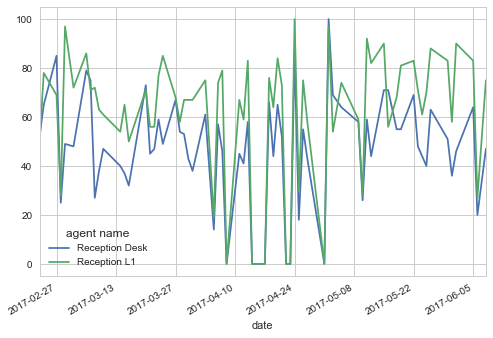

In [37]:
agent_data_by_date.loc[['Reception Desk', 'Reception L1'], 'num calls handled',].T.plot(kind='line')

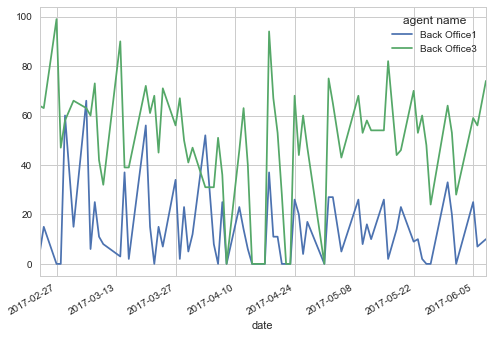

In [38]:
agent_data_by_date.loc[['Back Office1', 'Back Office3'], 'num calls handled',].T.plot(kind='line')

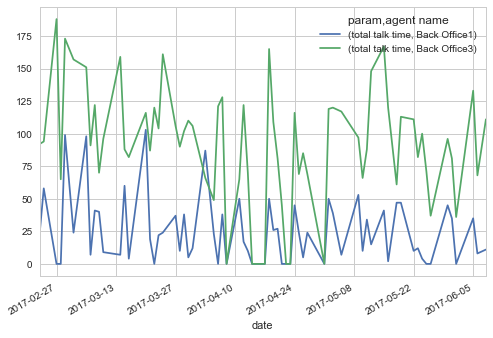

In [39]:
agent_data_clean.unstack('agent name').loc[:,[('total talk time', 'Back Office1'), ('total talk time', 'Back Office3')]].astype('timedelta64[m]').astype(int).plot()

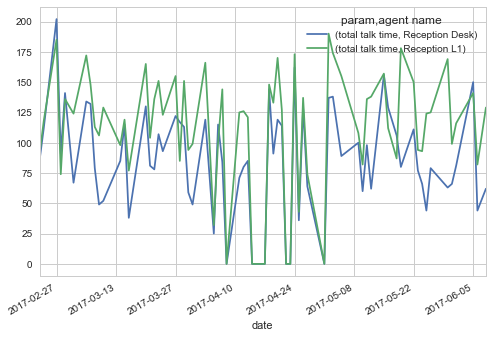

In [40]:
agent_data_clean.unstack('agent name').loc[:,[('total talk time', 'Reception Desk'), ('total talk time', 'Reception L1')]].astype('timedelta64[m]').astype(int).plot()

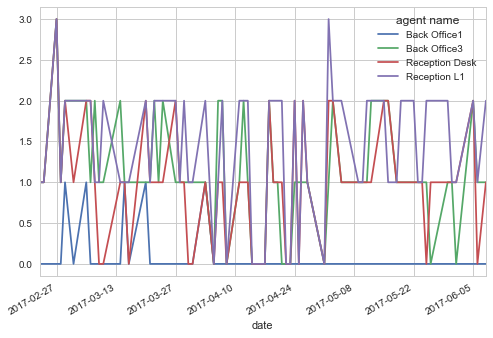

In [41]:
agent_data_clean.unstack('agent name').loc[:,'total talk time'].astype('timedelta64[h]').astype(int).plot()

In [42]:
agent_data_clean.unstack('agent name').loc[:,'avg wait time'].astype('timedelta64[s]').astype(int).plot()

KeyError: 'the label [avg wait time] is not in the [columns]'

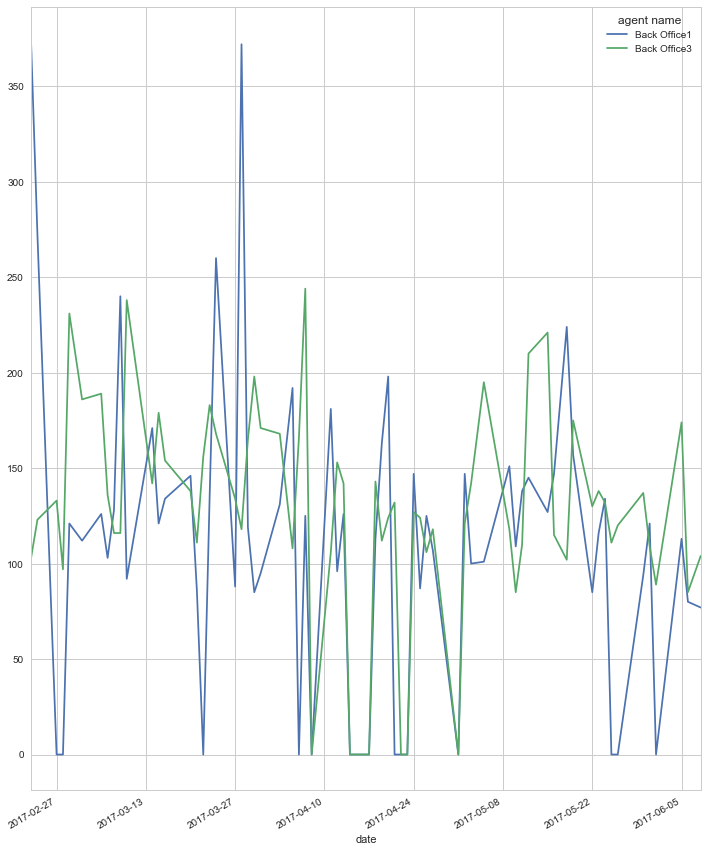

In [43]:
q = agent_data_by_date.loc[['Back Office1', 'Back Office3'],'avg call time'].T.astype('timedelta64[s]').astype(int)
fig, ax = plt.subplots(figsize=(12,16))
q.plot(kind='line', ax=ax)

In [193]:
group_data = concat_data(group_files)
print(group_data.shape)
# group_data.to_csv('../raw_data/group_data.tsv', sep='\t')
group_data.head(10)


(6528, 11)


param                         timestamp  num busy overflows  \
date       time                                               
2017-02-23 00:00:00 2017-02-23 00:00:00                   0   
           00:15:00 2017-02-23 00:15:00                   0   
           00:30:00 2017-02-23 00:30:00                   0   
           00:45:00 2017-02-23 00:45:00                   0   
           01:00:00 2017-02-23 01:00:00                   0   
           01:15:00 2017-02-23 01:15:00                   0   
           01:30:00 2017-02-23 01:30:00                   0   
           01:45:00 2017-02-23 01:45:00                   0   
           02:00:00 2017-02-23 02:00:00                   0   
           02:15:00 2017-02-23 02:15:00                   0   

param                num calls answered  num calls abandoned  \
date       time                                                
2017-02-23 00:00:00                   0                    0   
           00:15:00                   0                    0   
           00:30:00                   0                    0   
           00:45:00                   0                    0   
           01:00:00                   0                    0   
           01:15:00                   0                    0   
           01:30:00                   0                    0   
           01:45:00                   0                    0   
           02:00:00                   0                    0   
           02:15:00                   0                    0   

param                num calls transferred  num calls timed out  \
date       time                                                   
2017-02-23 00:00:00                      0                    0   
           00:15:00                      0                    0   
           00:30:00                      0                    0   
           00:45:00                      0                    0   
           01:00:00                      0                    0   
           01:15:00                      0                    0   
           01:30:00                      0                    0   
           01:45:00                      0                    0   
           02:00:00                      0                    0   
           02:15:00                      0                    0   

param                avg num agents talking  avg num agents staffed  \
date       time                                                       
2017-02-23 00:00:00                     0.0                     4.0   
           00:15:00                     0.0                     4.0   
           00:30:00                     0.0                     4.0   
           00:45:00                     0.0                     4.0   
           01:00:00                     0.0                     4.0   
           01:15:00                     0.0                     4.0   
           01:30:00                     0.0                     4.0   
           01:45:00                     0.0                     4.0   
           02:00:00                     0.0                     4.0   
           02:15:00                     0.0                     4.0   

param               avg wait time avg abandonment time  \
date       time                                          
2017-02-23 00:00:00        0 days               0 days   
           00:15:00        0 days               0 days   
           00:30:00        0 days               0 days   
           00:45:00        0 days               0 days   
           01:00:00        0 days               0 days   
           01:15:00        0 days               0 days   
           01:30:00        0 days               0 days   
           01:45:00        0 days               0 days   
           02:00:00        0 days               0 days   
           02:15:00        0 days               0 days   

param                                            filename  
date       time                                            

In [187]:
group_data.head()

param                         timestamp  num busy overflows  \
date       time                                               
2017-02-23 00:00:00 2017-02-23 00:00:00                   0   
           00:15:00 2017-02-23 00:15:00                   0   
           00:30:00 2017-02-23 00:30:00                   0   
           00:45:00 2017-02-23 00:45:00                   0   
           01:00:00 2017-02-23 01:00:00                   0   

param                num calls answered  num calls abandoned  \
date       time                                                
2017-02-23 00:00:00                   0                    0   
           00:15:00                   0                    0   
           00:30:00                   0                    0   
           00:45:00                   0                    0   
           01:00:00                   0                    0   

param                num calls transferred  num calls timed out  \
date       time                                                   
2017-02-23 00:00:00                      0                    0   
           00:15:00                      0                    0   
           00:30:00                      0                    0   
           00:45:00                      0                    0   
           01:00:00                      0                    0   

param                avg num agents talking  avg num agents staffed  \
date       time                                                       
2017-02-23 00:00:00                     0.0                     4.0   
           00:15:00                     0.0                     4.0   
           00:30:00                     0.0                     4.0   
           00:45:00                     0.0                     4.0   
           01:00:00                     0.0                     4.0   

param               avg wait time avg abandonment time  \
date       time                                          
2017-02-23 00:00:00        0 days               0 days   
           00:15:00        0 days               0 days   
           00:30:00        0 days               0 days   
           00:45:00        0 days               0 days   
           01:00:00        0 days               0 days   

param                                            filename  
date       time                                            
2017-02-23 00:00:00  20170223_000000_group_statistics.csv  
           00:15:00  20170223_000000_group_statistics.csv  
           00:30:00  20170223_000000_group_statistics.csv  
           00:45:00  20170223_000000_group_statistics.csv  
           01:00:00  20170223_000000_group_statistics.csv

In [188]:
agent_data.head()

param                      num calls handled  num calls unanswered  \
date       agent name                                                
2017-02-23 Reception L1                   49                    50   
           Back Office3                   64                    62   
           Reception Desk                 52                    45   
           Back Office1                    4                     3   
2017-02-24 Reception L1                   78                    57   

param                     avg call time total talk time total staffed time  \
date       agent name                                                        
2017-02-23 Reception L1        00:02:11        01:30:45             1 days   
           Back Office3        00:01:43        01:32:51             1 days   
           Reception Desk      00:01:53        01:25:32             1 days   
           Back Office1        00:06:13        00:22:45             1 days   
2017-02-24 Reception L1        00:02:21        01:58:45             1 days   

param                                                  filename  
date       agent name                                            
2017-02-23 Reception L1    20170223_000000_agent_statistics.csv  
           Back Office3    20170223_000000_agent_statistics.csv  
           Reception Desk  20170223_000000_agent_statistics.csv  
           Back Office1    20170223_000000_agent_statistics.csv  
2017-02-24 Reception L1    20170224_000000_agent_statistics.csv

In [46]:
group_data['avg wait time'] = group_data['avg wait time'].astype('timedelta64[s]')
group_data.head()

param                         timestamp  num busy overflows  \
date       time                                               
2017-02-23 00:00:00 2017-02-23 00:00:00                   0   
           00:15:00 2017-02-23 00:15:00                   0   
           00:30:00 2017-02-23 00:30:00                   0   
           00:45:00 2017-02-23 00:45:00                   0   
           01:00:00 2017-02-23 01:00:00                   0   

param                num calls answered  num calls abandoned  \
date       time                                                
2017-02-23 00:00:00                   0                    0   
           00:15:00                   0                    0   
           00:30:00                   0                    0   
           00:45:00                   0                    0   
           01:00:00                   0                    0   

param                num calls transferred  num calls timed out  \
date       time                                                   
2017-02-23 00:00:00                      0                    0   
           00:15:00                      0                    0   
           00:30:00                      0                    0   
           00:45:00                      0                    0   
           01:00:00                      0                    0   

param                avg num agents talking  avg num agents staffed  \
date       time                                                       
2017-02-23 00:00:00                     0.0                     4.0   
           00:15:00                     0.0                     4.0   
           00:30:00                     0.0                     4.0   
           00:45:00                     0.0                     4.0   
           01:00:00                     0.0                     4.0   

param               avg wait time avg abandonment time  \
date       time                                          
2017-02-23 00:00:00        0 days               0 days   
           00:15:00        0 days               0 days   
           00:30:00        0 days               0 days   
           00:45:00        0 days               0 days   
           01:00:00        0 days               0 days   

param                                            filename  
date       time                                            
2017-02-23 00:00:00  20170223_000000_group_statistics.csv  
           00:15:00  20170223_000000_group_statistics.csv  
           00:30:00  20170223_000000_group_statistics.csv  
           00:45:00  20170223_000000_group_statistics.csv  
           01:00:00  20170223_000000_group_statistics.csv

In [122]:
group_data.index.get_level_values(0)

DatetimeIndex(['2017-02-23', '2017-02-23', '2017-02-23', '2017-02-23',
               '2017-02-23', '2017-02-23', '2017-02-23', '2017-02-23',
               '2017-02-23', '2017-02-23',
               ...
               '2017-06-08', '2017-06-08', '2017-06-08', '2017-06-08',
               '2017-06-08', '2017-06-08', '2017-06-08', '2017-06-08',
               '2017-06-08', '2017-06-08'],
              dtype='datetime64[ns]', name='date', length=6528, freq=None)

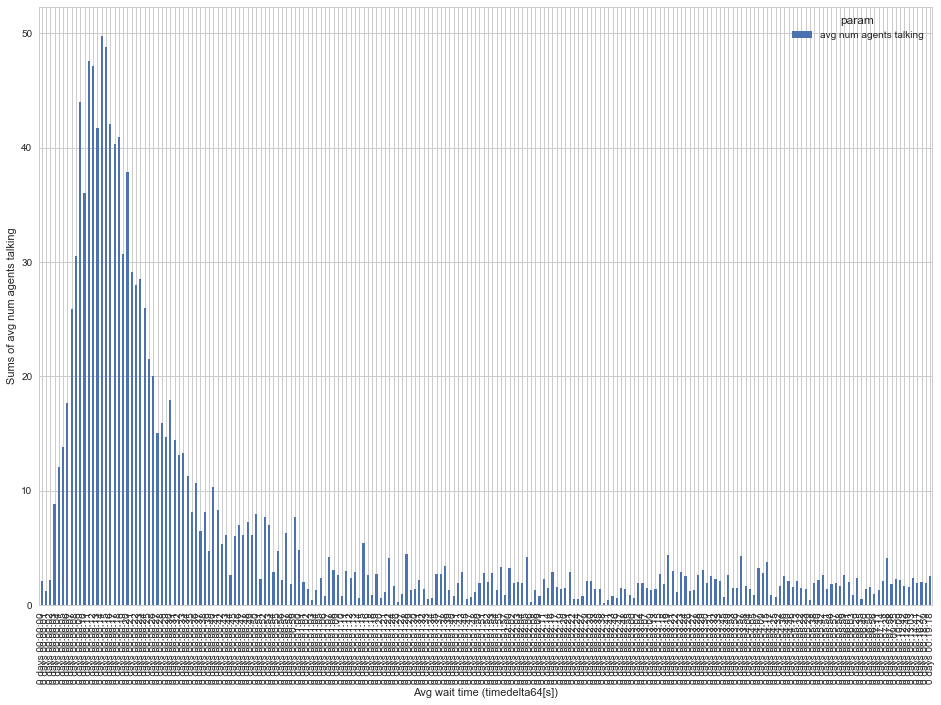

In [186]:
fig, ax = plt.subplots(figsize=(16,11))

q = group_data[['avg num agents talking', 'avg wait time']].reset_index().drop(['date', 'time'], axis=1)
q['avg wait time'] = q['avg wait time']  # optional .astype('timedelta64[s]').astype(int)
gb = q.groupby(by='avg wait time').sum()
gb.plot(kind='bar', ax=ax)
ax.set_ylabel('Sums of avg num agents talking')
ax.set_xlabel('Avg wait time (timedelta64[s])')

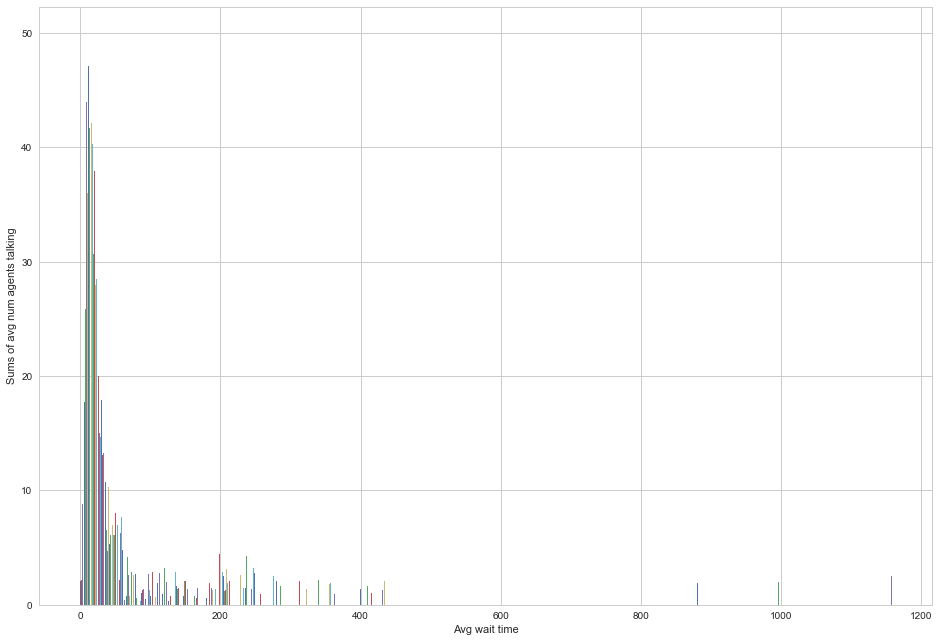

In [185]:
fig, ax = plt.subplots(figsize=(16,11))

q = group_data[['avg num agents talking', 'avg wait time']].reset_index().drop(['date', 'time'], axis=1)
q['avg wait time'] = q['avg wait time'].astype('timedelta64[s]').astype(int)

for cluster, df in q.groupby(by='avg wait time'):
#     print(cluster, df['avg num agents talking'].sum())
    ax.bar(cluster, df['avg num agents talking'].sum())
ax.set_ylabel('Sums of avg num agents talking')
ax.set_xlabel('Avg wait time')

In [88]:
group_data.index.get_level_values('date')

DatetimeIndex(['2017-02-23', '2017-02-23', '2017-02-23', '2017-02-23',
               '2017-02-23', '2017-02-23', '2017-02-23', '2017-02-23',
               '2017-02-23', '2017-02-23',
               ...
               '2017-06-08', '2017-06-08', '2017-06-08', '2017-06-08',
               '2017-06-08', '2017-06-08', '2017-06-08', '2017-06-08',
               '2017-06-08', '2017-06-08'],
              dtype='datetime64[ns]', name='date', length=6528, freq=None)

In [198]:
unstacked = group_data.unstack('date').drop(['timestamp', 'filename'], axis=1)
unstacked.to_csv('../raw_data/group_data_by_date.tsv', sep='\t')

In [89]:
group_data.unstack('date')['num calls answered'].columns

DatetimeIndex(['2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28',
               '2017-03-01', '2017-03-03', '2017-03-06', '2017-03-08',
               '2017-03-09', '2017-03-10', '2017-03-13', '2017-03-14',
               '2017-03-15', '2017-03-16', '2017-03-17', '2017-03-20',
               '2017-03-21', '2017-03-22', '2017-03-23', '2017-03-24',
               '2017-03-27', '2017-03-28', '2017-03-30', '2017-03-31',
               '2017-04-03', '2017-04-04', '2017-04-05', '2017-04-07',
               '2017-04-08', '2017-04-11', '2017-04-12', '2017-04-13',
               '2017-04-14', '2017-04-16', '2017-04-17', '2017-04-18',
               '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22',
               '2017-04-23', '2017-04-24', '2017-04-25', '2017-04-26',
               '2017-04-27', '2017-05-01', '2017-05-02', '2017-05-03',
               '2017-05-05', '2017-05-08', '2017-05-09', '2017-05-10',
               '2017-05-11', '2017-05-12', '2017-05-15', '2017-05-16',
      

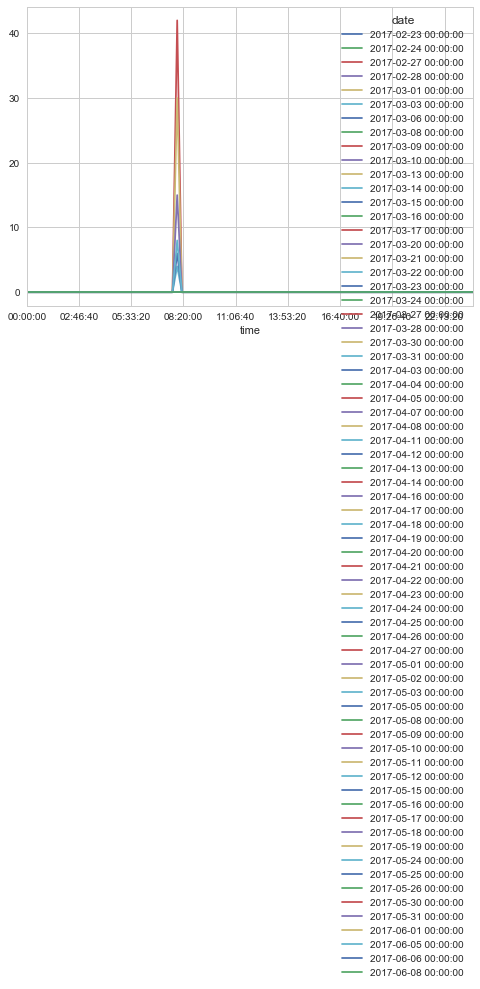

In [90]:
group_data.unstack('date')['num busy overflows'].plot()

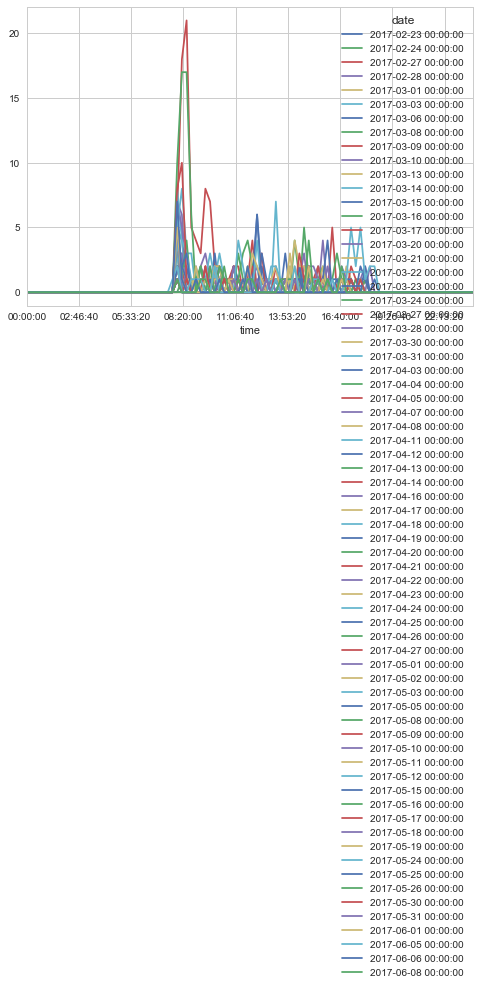

In [91]:
group_data.unstack('date')['num calls abandoned'].plot()

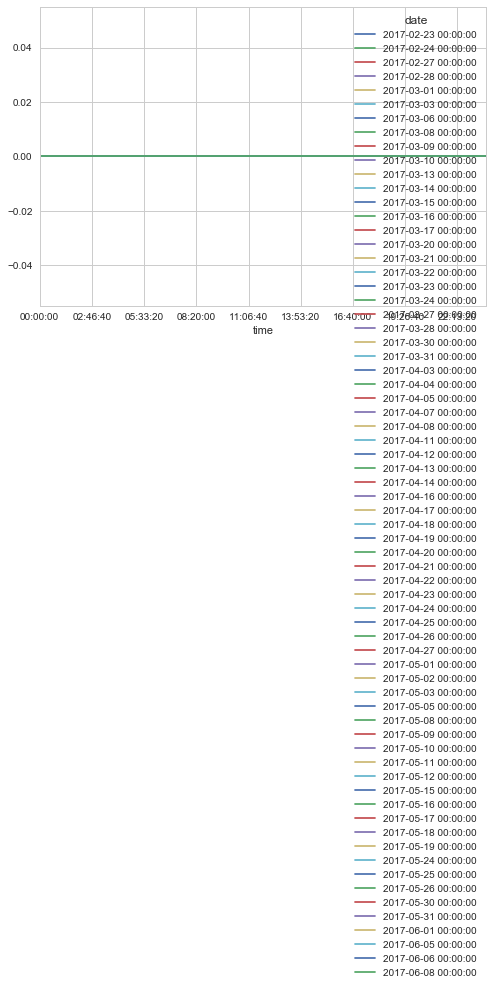

In [92]:
group_data.unstack('date')['num calls transferred'].plot()

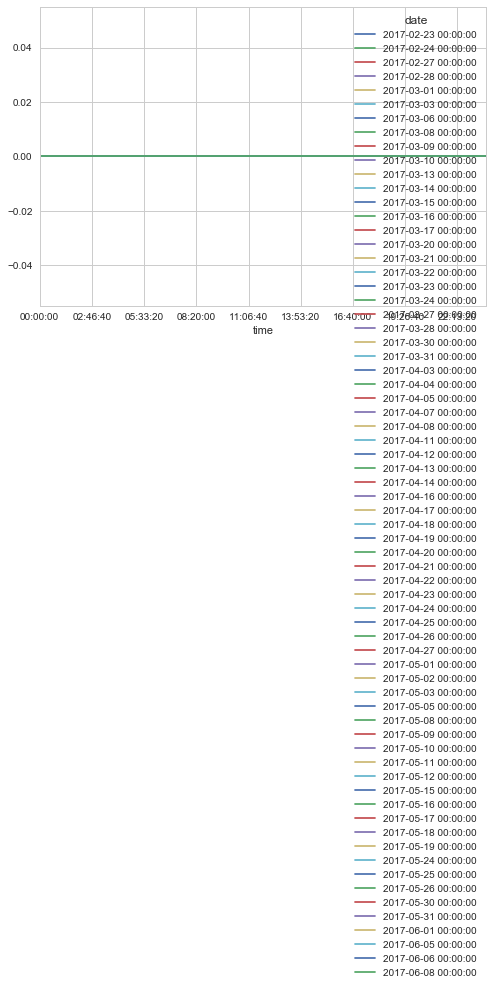

In [93]:
group_data.unstack('date')['num calls timed out'].plot()

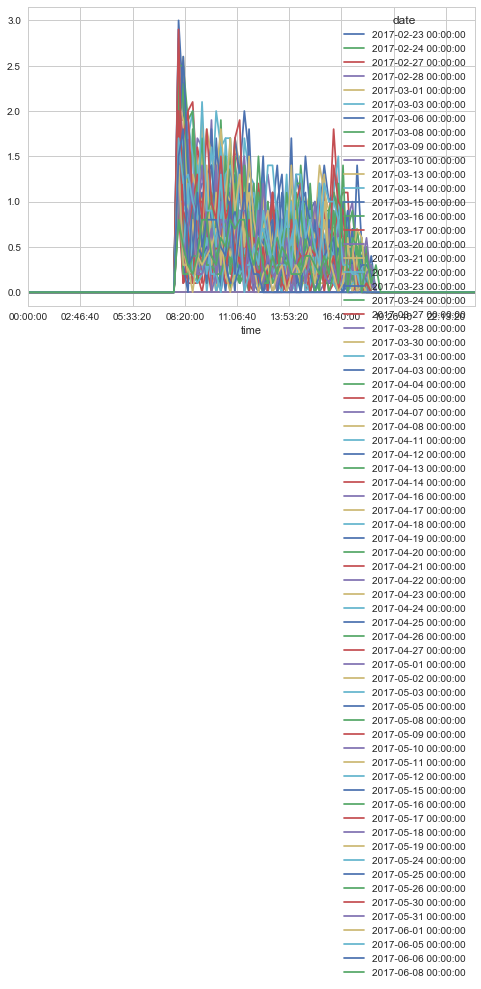

In [94]:
group_data.unstack('date')['avg num agents talking'].plot()

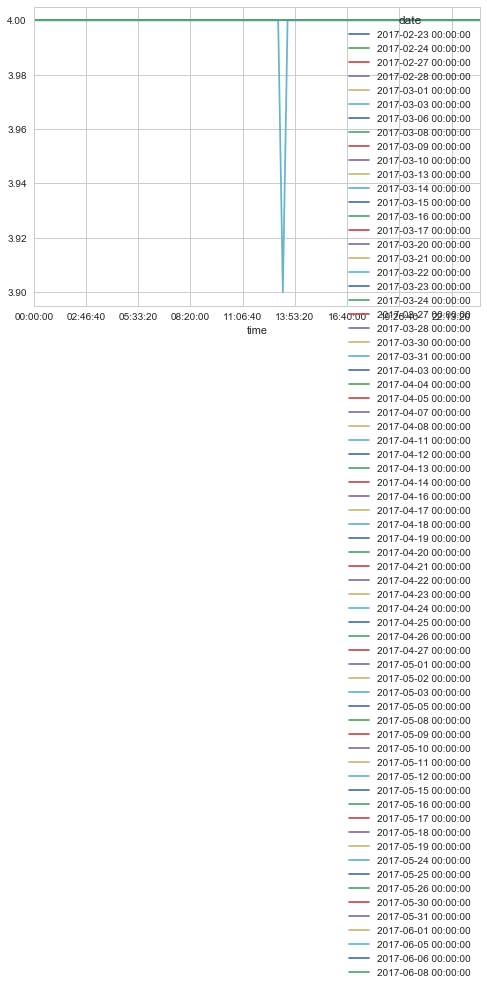

In [95]:
group_data.unstack('date')['avg num agents staffed'].plot()

In [74]:
q = group_data.unstack('date')['avg wait time']
# q.rename(columns=lambda x: x.date(), inplace=True)
q.columns

DatetimeIndex(['2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28',
               '2017-03-01', '2017-03-03', '2017-03-06', '2017-03-08',
               '2017-03-09', '2017-03-10', '2017-03-13', '2017-03-14',
               '2017-03-15', '2017-03-16', '2017-03-17', '2017-03-20',
               '2017-03-21', '2017-03-22', '2017-03-23', '2017-03-24',
               '2017-03-27', '2017-03-28', '2017-03-30', '2017-03-31',
               '2017-04-03', '2017-04-04', '2017-04-05', '2017-04-07',
               '2017-04-08', '2017-04-11', '2017-04-12', '2017-04-13',
               '2017-04-14', '2017-04-16', '2017-04-17', '2017-04-18',
               '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22',
               '2017-04-23', '2017-04-24', '2017-04-25', '2017-04-26',
               '2017-04-27', '2017-05-01', '2017-05-02', '2017-05-03',
               '2017-05-05', '2017-05-08', '2017-05-09', '2017-05-10',
               '2017-05-11', '2017-05-12', '2017-05-15', '2017-05-16',
      

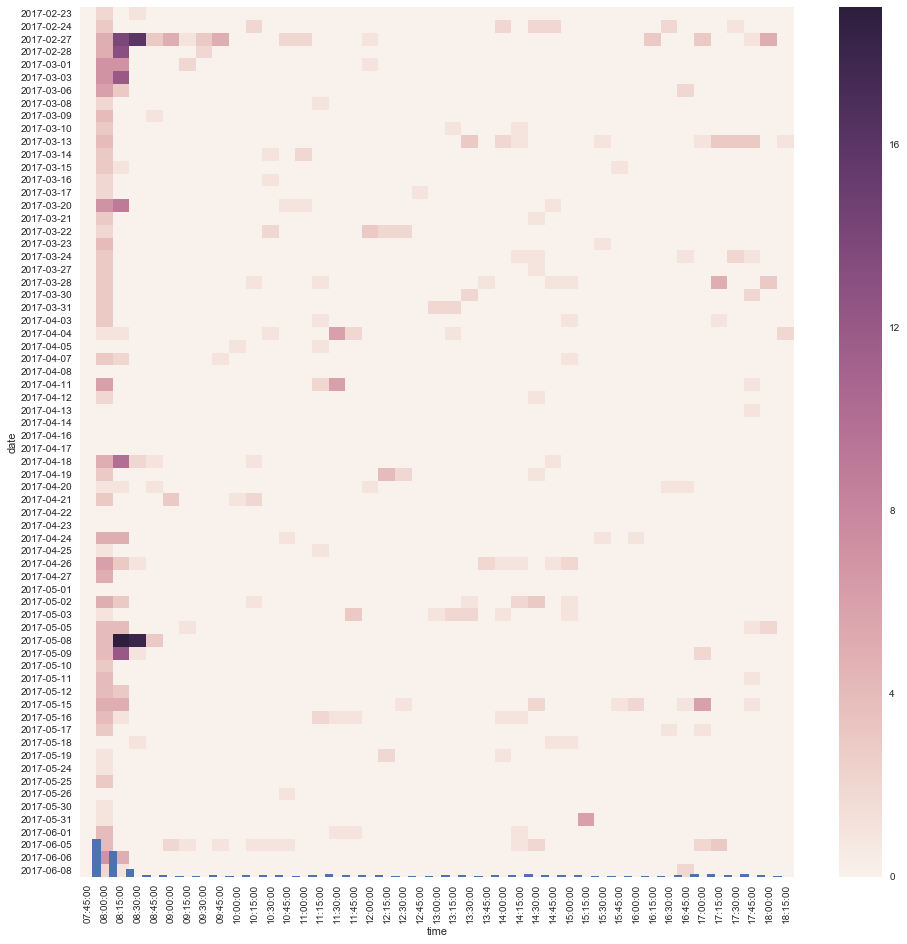

In [76]:
q = group_data.unstack('date')['avg wait time'].astype('timedelta64[m]')
q.rename(columns=lambda x: x.date(), inplace=True)
mask = np.logical_and(q.index >= datetime(1900,1,1,7,45,0).time(), q.index <= datetime(1900,1,1,18,15,0).time())
q = q.loc[mask]
fig, ax = plt.subplots(figsize=(16,16))
q.mean(axis=1).plot(kind='bar', ax=ax, )
sns.heatmap(q.T, ax=ax)

0.0


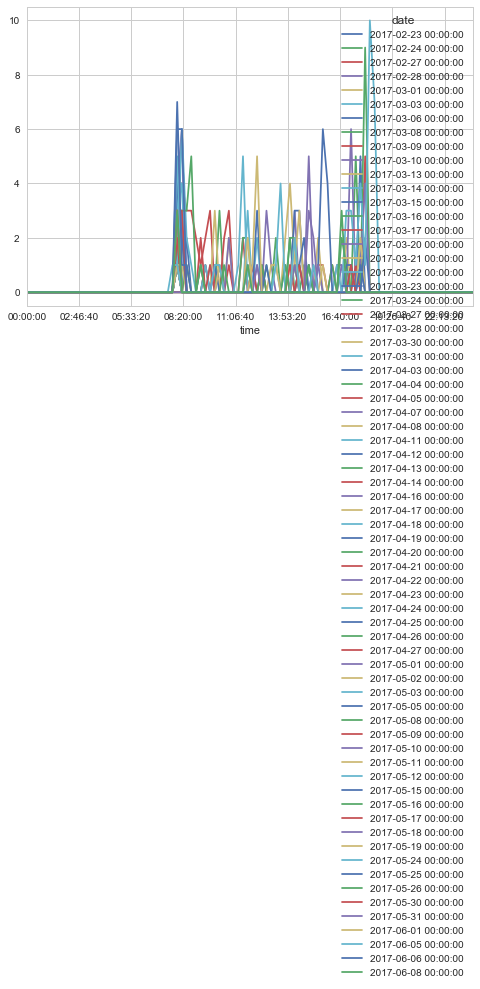

In [79]:
avg_abandonment_time = group_data['avg abandonment time'].astype('timedelta64[m]')
print(avg_abandonment_time.quantile(q=0.95))
avg_abandonment_time.unstack('date').plot()

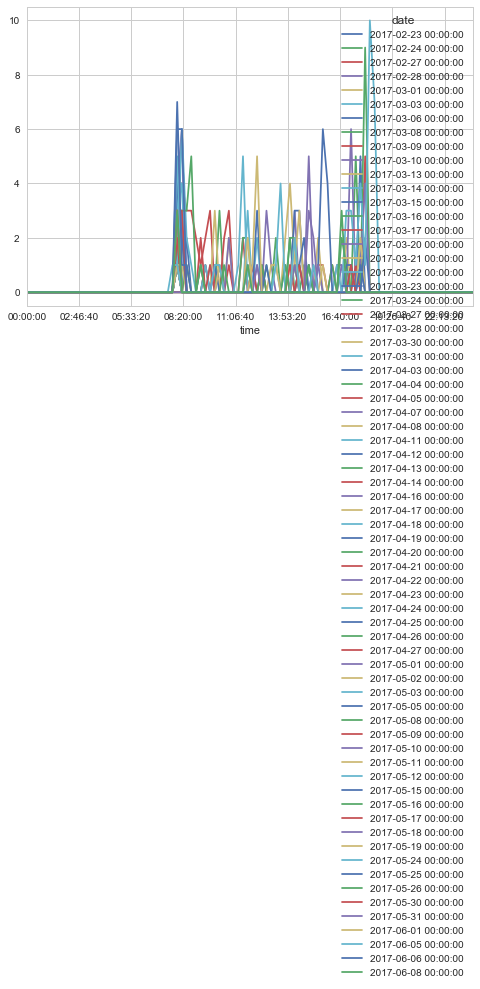

In [80]:
q = avg_abandonment_time.unstack('date')
q.plot()

In [81]:
# ind = q.index.get_level_values(0)
# dow = [x.weekday() for x in ind]
# ind
group_data['num calls answered'].unstack('date').T.index

DatetimeIndex(['2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28',
               '2017-03-01', '2017-03-03', '2017-03-06', '2017-03-08',
               '2017-03-09', '2017-03-10', '2017-03-13', '2017-03-14',
               '2017-03-15', '2017-03-16', '2017-03-17', '2017-03-20',
               '2017-03-21', '2017-03-22', '2017-03-23', '2017-03-24',
               '2017-03-27', '2017-03-28', '2017-03-30', '2017-03-31',
               '2017-04-03', '2017-04-04', '2017-04-05', '2017-04-07',
               '2017-04-08', '2017-04-11', '2017-04-12', '2017-04-13',
               '2017-04-14', '2017-04-16', '2017-04-17', '2017-04-18',
               '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22',
               '2017-04-23', '2017-04-24', '2017-04-25', '2017-04-26',
               '2017-04-27', '2017-05-01', '2017-05-02', '2017-05-03',
               '2017-05-05', '2017-05-08', '2017-05-09', '2017-05-10',
               '2017-05-11', '2017-05-12', '2017-05-15', '2017-05-16',
      

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


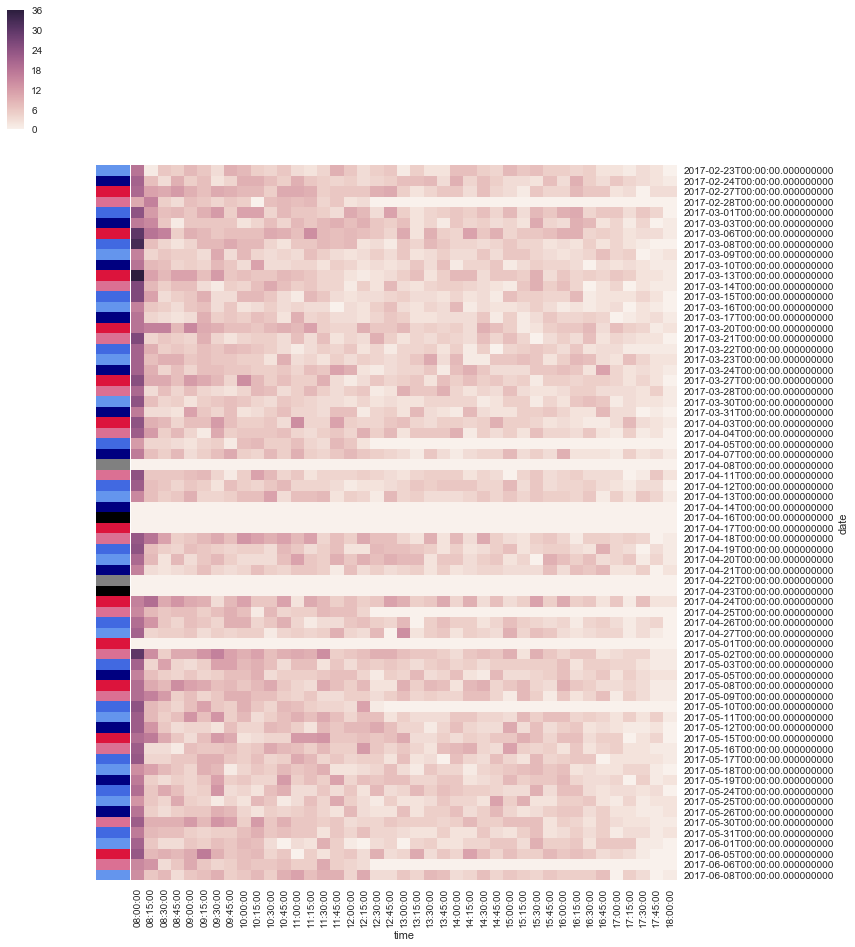

In [83]:
query = group_data['num calls answered'].unstack('date')
day_of_week = [x.weekday() for x in group_data['num calls answered'].unstack('date').T.index]
mask = np.logical_and(query.index >= datetime(1900,1,1,8,0,0).time(), query.index < datetime(1900,1,1,18,15,0).time())
query = pd.DataFrame(query, index=query.index)

# fig, ax = plt.subplots(figsize=(12,16))
day_to_color = {0:'Crimson', 1:'PaleVioletRed', 2:'RoyalBlue', 3:'CornflowerBlue', 4:'Navy', 5:'Grey', 6:'Black'}
day_colors = [day_to_color[day] for day in day_of_week]
g = sns.clustermap(query[mask].T, col_cluster=False, row_cluster=False, figsize=(12,16), method='ward', row_colors=day_colors)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0,);


In [ ]:
# fig, ax = plt.subplots(figsize=(16,8))
# unstacked = q.unstack('date')
# unstacked.mean(axis=1).unstack('day').plot(kind='bar', ax=ax)
# # gp = q.groupby(q.day)

In [ ]:
for x in gp:
    print (x)